In [6]:
#Import and setup
import os
import sys
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display, Markdown

# Add project root to path
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
sys.path.append(os.getcwd())

from src.config import PROCESSED_DATA_PATH, MODEL_SAVE_PATH

In [7]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

model_path = os.path.join(MODEL_SAVE_PATH, "distilbert_sentiment")

model = DistilBertForSequenceClassification.from_pretrained(model_path)
tokenizer = DistilBertTokenizer.from_pretrained(model_path)
model.eval()


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [17]:
import pandas as pd
import random
from collections import defaultdict
from src.config import PROCESSED_DATA_PATH, LANGUAGES

label_map = {"Negative": 0, "Neutral": 1, "Positive": 2}
inv_label_map = {v: k for k, v in label_map.items()}

# Configurable
total_rows = 1_200_000
rows_to_load = 100_000
n_per_class_per_lang = 50

# Track collected languages and results
collected_languages = set()
lang_sentiment_counts = {}
samples = []

attempt = 0
max_attempts = 20  # safety cap

while len(collected_languages) < len(LANGUAGES) and attempt < max_attempts:
    attempt += 1
    start_row = random.randint(1, total_rows - rows_to_load)
    print(f"📦 Attempt {attempt}: Reading rows {start_row} to {start_row + rows_to_load}...")

    # Read chunk
    df_chunk = pd.read_csv(
        PROCESSED_DATA_PATH,
        skiprows=range(1, start_row),  # skip header + rows
        nrows=rows_to_load,
    )

    # Filter to supported langs not already collected
    df_chunk = df_chunk[df_chunk["language"].isin([l for l in LANGUAGES if l not in collected_languages])]
    if df_chunk.empty:
        continue

    df_chunk = df_chunk.sample(frac=1, random_state=42).reset_index(drop=True)

    for lang in df_chunk["language"].unique():
        if lang in collected_languages:
            continue

        df_lang = df_chunk[df_chunk["language"] == lang]
        per_lang_samples = []

        for sentiment in label_map:
            df_sent = df_lang[df_lang["sentiment"] == sentiment]
            take_n = min(len(df_sent), n_per_class_per_lang)
            if take_n > 0:
                per_lang_samples.append(df_sent.head(take_n))
                lang_sentiment_counts[(lang, sentiment)] = take_n

        if per_lang_samples:
            samples.extend(per_lang_samples)
            collected_languages.add(lang)
            print(f"✅ Collected language: {lang} ✅")

print("\n🎉 Done collecting 6 languages.")
print("Collected languages:", sorted(collected_languages))

# Combine and finalize
df_sample = pd.concat(samples).reset_index(drop=True)
df_sample["label"] = df_sample["sentiment"].map(label_map)
texts = df_sample["text_for_model"].tolist()
true_labels = df_sample["label"].tolist()

# Summary
print("\n✅ Final Sampled Sentiment Counts:", df_sample["sentiment"].value_counts().to_dict())
print("✅ Final Language Breakdown:", df_sample["language"].value_counts().to_dict())

print("\n📊 Per-language Sentiment Sample Counts:")
for (lang, sent), count in sorted(lang_sentiment_counts.items()):
    print(f"{lang} - {sent}: {count}")


📦 Attempt 1: Reading rows 552018 to 652018...
✅ Collected language: fr ✅
✅ Collected language: es ✅
📦 Attempt 2: Reading rows 582630 to 682630...
📦 Attempt 3: Reading rows 609418 to 709418...
📦 Attempt 4: Reading rows 476031 to 576031...
📦 Attempt 5: Reading rows 839300 to 939300...
✅ Collected language: ja ✅
📦 Attempt 6: Reading rows 968638 to 1068638...
✅ Collected language: zh ✅
📦 Attempt 7: Reading rows 24678 to 124678...
✅ Collected language: de ✅
📦 Attempt 8: Reading rows 76297 to 176297...
📦 Attempt 9: Reading rows 517392 to 617392...
📦 Attempt 10: Reading rows 675961 to 775961...
📦 Attempt 11: Reading rows 339982 to 439982...
✅ Collected language: en ✅

🎉 Done collecting 6 languages.
Collected languages: ['de', 'en', 'es', 'fr', 'ja', 'zh']

✅ Final Sampled Sentiment Counts: {'Negative': 200, 'Positive': 200, 'Neutral': 100}
✅ Final Language Breakdown: {'ja': 150, 'de': 150, 'fr': 50, 'es': 50, 'zh': 50, 'en': 50}

📊 Per-language Sentiment Sample Counts:
de - Negative: 50
de - 

In [22]:
from tqdm import tqdm
import torch

# ✅ Ensure consistency before inference
texts = df_sample["text_for_model"].tolist()
true_labels = df_sample["label"].tolist()
assert len(texts) == len(true_labels), "❌ Mismatch between texts and labels."

# ✅ Tokenize all at once
inputs = tokenizer(
    texts,
    padding=True,
    truncation=True,
    max_length=32,
    return_tensors="pt"
)

# ✅ Run inference in batches
batch_size = 64
preds = []

with torch.no_grad():
    for i in tqdm(range(0, len(texts), batch_size), desc="Running inference"):
        input_ids = inputs["input_ids"][i:i+batch_size]
        attn_mask = inputs["attention_mask"][i:i+batch_size]
        outputs = model(input_ids=input_ids, attention_mask=attn_mask)
        preds.extend(torch.argmax(outputs.logits, dim=1).tolist())

# ✅ Attach predictions
df_sample["predicted_label"] = preds
df_sample["predicted_sentiment"] = df_sample["predicted_label"].map(inv_label_map)

# ✅ Prediction distribution
print("📊 Predicted sentiment distribution:")
print(df_sample["predicted_sentiment"].value_counts())


Running inference: 100%|██████████| 8/8 [00:23<00:00,  2.91s/it]


📊 Predicted sentiment distribution:
predicted_sentiment
Negative    356
Positive    125
Neutral      19
Name: count, dtype: int64


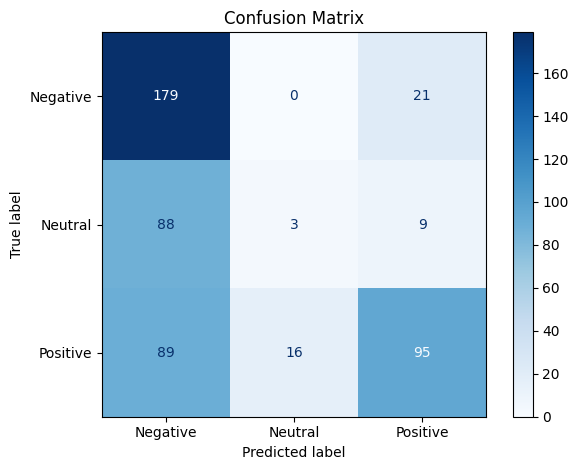


📄 Classification Report:

              precision    recall  f1-score   support

    Negative       0.50      0.90      0.64       200
     Neutral       0.16      0.03      0.05       100
    Positive       0.76      0.47      0.58       200

    accuracy                           0.55       500
   macro avg       0.47      0.47      0.43       500
weighted avg       0.54      0.55      0.50       500



In [23]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from src.config import REPORTS_PATH
import matplotlib.pyplot as plt
import os

# ✅ Check match
assert len(true_labels) == len(preds), "Mismatch in lengths of true and predicted labels."

# ✅ Handle present labels only
unique_labels = sorted(set(true_labels + preds))
label_names = ["Negative", "Neutral", "Positive"]
present_labels = [label_names[i] for i in unique_labels]

# ✅ Plot and save confusion matrix
cm = confusion_matrix(true_labels, preds, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=present_labels)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.tight_layout()
os.makedirs(REPORTS_PATH, exist_ok=True)
plt.savefig(os.path.join(REPORTS_PATH, "confusion_matrix.png"))
plt.show()

# ✅ Print classification report
report = classification_report(true_labels, preds, labels=unique_labels, target_names=present_labels)
print("\n📄 Classification Report:\n")
print(report)


C:\Users\hp\AppData\Local\Temp\ipykernel_12008\944028242.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lang_perf = df_sample.groupby("language").apply(


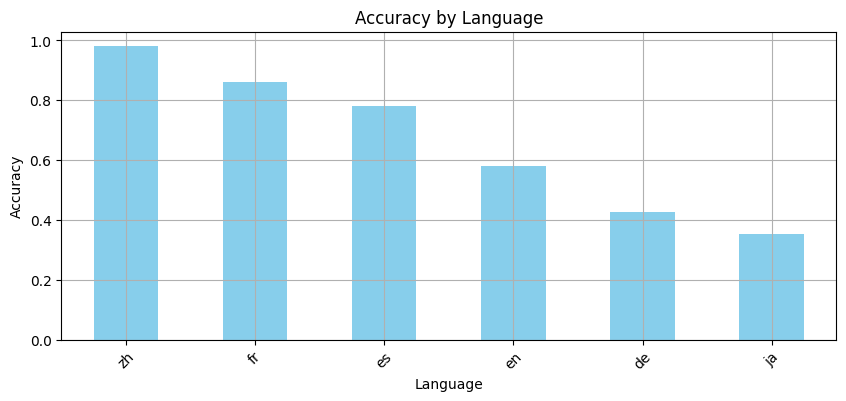

In [24]:
lang_perf = df_sample.groupby("language").apply(
    lambda g: (g["label"] == g["predicted_label"]).mean()
).sort_values(ascending=False)

lang_perf.plot(kind="bar", figsize=(10, 4), color="skyblue")
plt.title("Accuracy by Language")
plt.ylabel("Accuracy")
plt.xlabel("Language")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


C:\Users\hp\AppData\Local\Temp\ipykernel_12008\3118679096.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cat_perf = df_sample.groupby("product_category").apply(


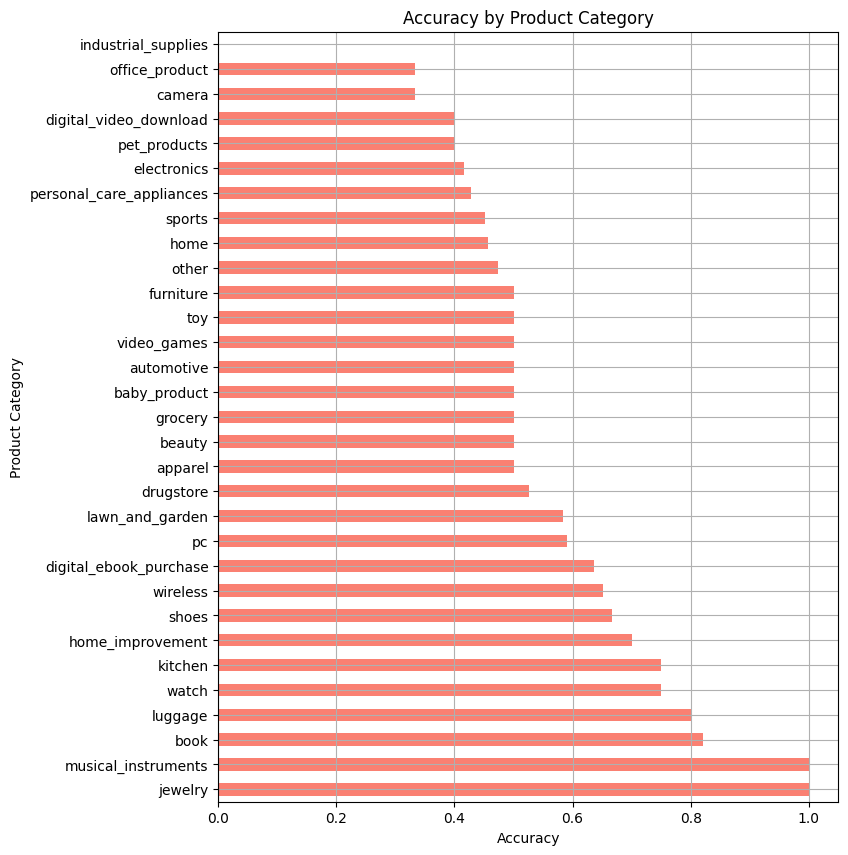

In [25]:
cat_perf = df_sample.groupby("product_category").apply(
    lambda g: (g["label"] == g["predicted_label"]).mean()
).sort_values(ascending=False)

cat_perf.plot(kind="barh", figsize=(8, 10), color="salmon")
plt.title("Accuracy by Product Category")
plt.xlabel("Accuracy")
plt.ylabel("Product Category")
plt.grid(True)
plt.show()


In [26]:
# Display 10 random misclassified examples
errors = df_sample[df_sample["label"] != df_sample["predicted_label"]]
if not errors.empty:
    display(errors[["review_body", "sentiment", "predicted_sentiment"]].sample(10, random_state=42))
else:
    print("🎉 No misclassifications in this sample.")


,review_body,sentiment,predicted_sentiment
60,Si no estaba muy convencido ahora lo estoy Re...,Positive,Negative
215,手触りが良いはじめから傷などがあるが自然にいる動物から頂戴したのだなあと感じられるのでそこも...,Positive,Negative
314,Hat immer Probleme mit dem WLAN,Negative,Positive
372,Naja Recht niedlich Aber klein und finde den P...,Neutral,Negative
485,Seems very healthy but I have to mix it with o...,Positive,Negative
248,サイズは丁度よくデザインも素敵で肌触りもよくお値段が安いのにとても素敵な商品でしたお気に入り...,Positive,Negative
196,頭皮が熱くなります 血行促進につながり髪が元気になれば良いです まだ効果は見られません,Neutral,Negative
238,自動でインストールされず検索してきてドライバー見つけた分マイナス1点で,Positive,Negative
409,Das Teil ist etwas knapp geschnitten und die S...,Positive,Neutral
425,Der Teller ist sehr schön auch von der Verarbe...,Positive,Negative


In [27]:
from sklearn.metrics import classification_report
import pandas as pd

# Per-class metrics
report_dict = classification_report(true_labels, preds, output_dict=True, target_names=present_labels)
df_report = pd.DataFrame(report_dict).transpose()

# Clean display
df_report = df_report.round(3)
display(Markdown("### 📋 Per-Class Metrics"))
display(df_report)

### 📋 Per-Class Metrics

,precision,recall,f1-score,support
Negative,0.503,0.895,0.644,200.000
Neutral,0.158,0.030,0.050,100.000
Positive,0.760,0.475,0.585,200.000
accuracy,0.554,0.554,0.554,0.554
macro avg,0.474,0.467,0.426,500.000
weighted avg,0.537,0.554,0.501,500.000


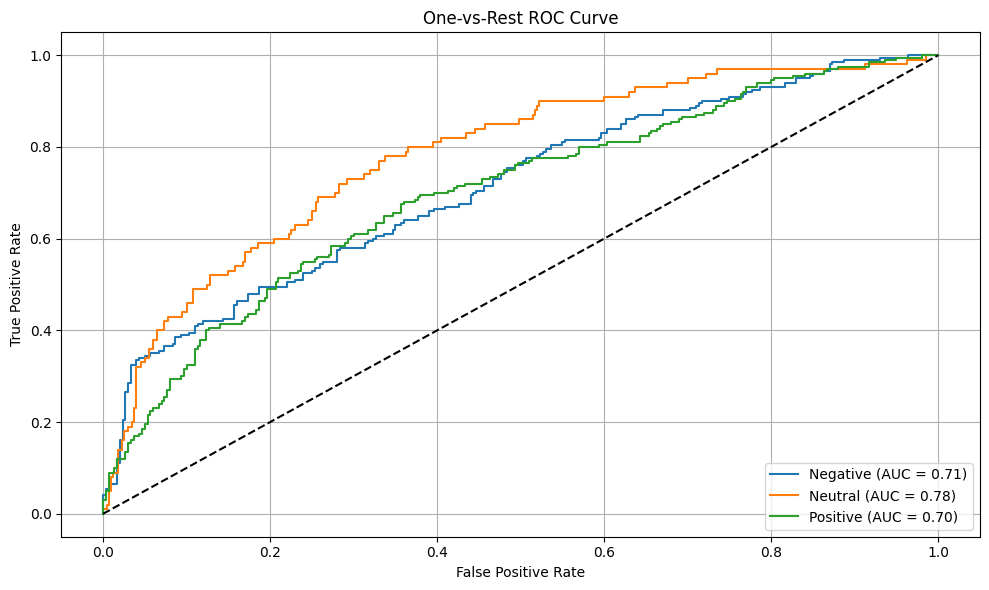

In [28]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay

# Binarize the labels
y_test_bin = label_binarize(true_labels, classes=unique_labels)
n_classes = y_test_bin.shape[1]

# Train a simple One-vs-Rest classifier using outputs
classifier = OneVsRestClassifier(LogisticRegression(max_iter=1000))
classifier.fit(inputs["input_ids"].numpy(), y_test_bin)

y_score = classifier.decision_function(inputs["input_ids"].numpy())

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 6))
for i, label in enumerate(present_labels):
    plt.plot(fpr[i], tpr[i], label=f"{label} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
